In [1]:
using Images
using Statistics
using Plots

In [2]:
function mask_site(file; n_sites=1)
    img = load(file)
    im_array = Float64.(img)
    frame_avg = mean(im_array, dims=(1,2))
    im_array = im_array ./ frame_avg
    im_array = im_array .- mean(im_array)
    # Use stack sum to find polarity patch(es)
    avgimg = mean(im_array, dims=(3))[:,:,1]
    max_bin = 0
    threshold = 0.55
    bin = avgimg .> maximum(avgimg)*threshold
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin             # Half max of average is used as threshold
        max_loc = findmax(bin.*avgimg)[2]              # Find single connected component from binary with highest value
        max_lab = bin_lab[max_loc]                  
        max_bin = bin_lab .== max_lab               # Make mask only around correct component
        im_masked = im_array .* max_bin
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

Loading: 100%|███████████████████████████████████████████| Time: 0:00:01


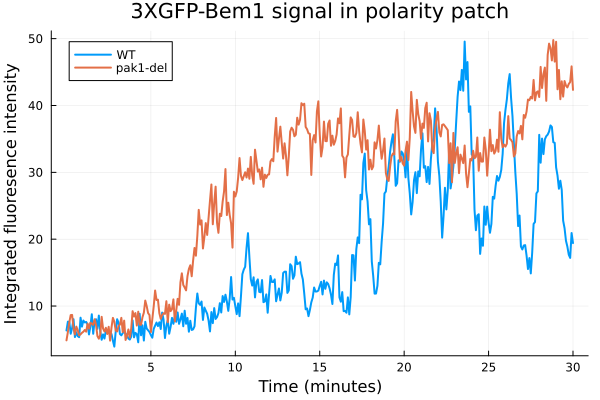

In [3]:
del_file = "../CroppedMovies/test.tif"
del = mask_site(del_file)
wt_file = "../CroppedMovies/NOTDEL-cell2.tif"
wt = mask_site(wt_file)
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, sum(wt, dims=(1,2))[1,1,:], xticks=range(1,6)*5, linewidth=2, label="WT", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")
plot!(t, sum(del, dims=(1,2))[1,1,:], linewidth=2, label="pak1-del", title="3XGFP-Bem1 signal in polarity patch")

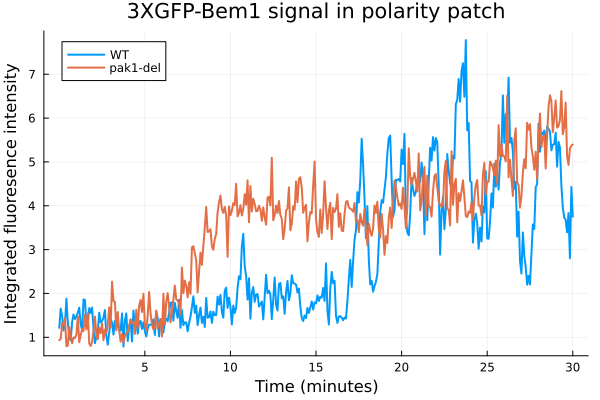

In [4]:
plot(t, maximum(wt, dims=(1,2))[1,1,:], xticks=range(1,6)*5, linewidth=2, label="WT", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")
plot!(t, maximum(del, dims=(1,2))[1,1,:], linewidth=2, label="pak1-del", title="3XGFP-Bem1 signal in polarity patch")

In [75]:
using DSP

In [76]:
sig_wt = sum(wt, dims=(1,2))[1,1,:]
pdg_wt = DSP.Periodograms.periodogram(sig_wt[200:end])
sig_del = sum(del, dims=(1,2))[1,1,:]
pdg_del = DSP.Periodograms.periodogram(sig_del[200:end])

DSP.Periodograms.Periodogram{Float64, AbstractFFTs.Frequencies{Float64}, Vector{Float64}}([214329.92609102774, 1111.5826303396188, 1446.6551424319384, 149.38612615578992, 116.31982846233366, 11.052228469760358, 3.470590396023828, 0.2992513112553904, 23.017077556984937, 7.251547268477485  …  7.25586797570844, 0.4974145484435061, 9.020226093595715, 6.781920425299658, 6.234912178050326, 11.05738942793719, 8.13944716598095, 0.06606027061640257, 10.26145748090147, 1.890887586643998], [0.0, 0.006172839506172839, 0.012345679012345678, 0.018518518518518517, 0.024691358024691357, 0.030864197530864196, 0.037037037037037035, 0.043209876543209874, 0.04938271604938271, 0.05555555555555555  …  0.4444444444444444, 0.4506172839506173, 0.4567901234567901, 0.4629629629629629, 0.4691358024691358, 0.47530864197530864, 0.48148148148148145, 0.48765432098765427, 0.49382716049382713, 0.5])

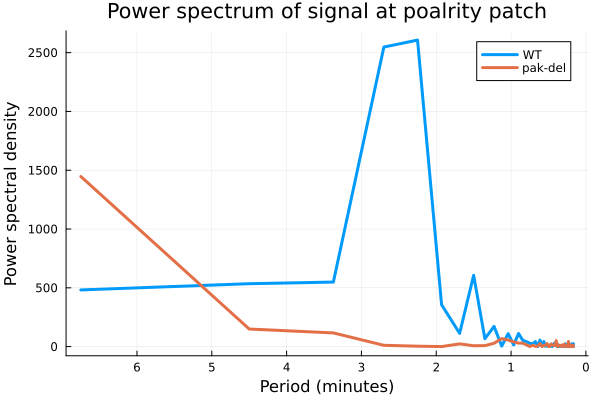

In [77]:
plot(1 ./ pdg_wt.freq[3:end] .* (5/60), pdg_wt.power[3:end], xflip = true, label="WT", linewidth=3, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_del.freq[3:end] .* (5/60), pdg_del.power[3:end], label="pak-del", xlabel="Period (minutes)", ylabel="Power spectral density", linewidth=3)
#savefig("tmp_PSD")

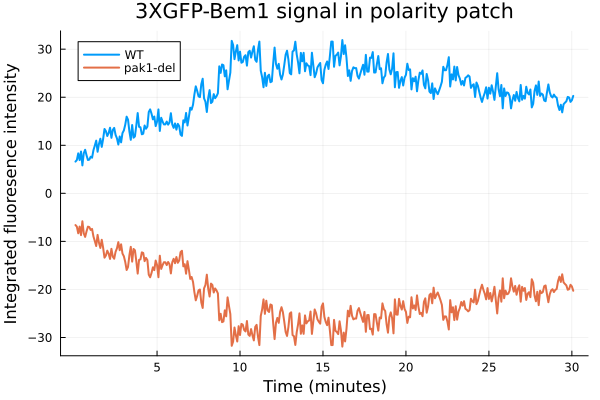

In [287]:
# Import iamge stack
del_2site_file = "../movies/2024_08_07-3XBG-pak1del/del-2patch/del-movie4-cell2.tif"
del_2 = mask_site(del_2site_file, n_sites=2)
del_site1 = del_2[:,:,:,1]
del_site2 = del_2[:,:,:,2]
t = range(1,length(im_masked[1,1,:]))/(60/5) # Convert from 1 frame every 5 sec, to minutes
plot(t, sum(del_site1, dims=(1,2))[1,1,:], xticks=range(1,6)*5, linewidth=2, label="WT", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")
plot!(t, sum(del_site2, dims=(1,2))[1,1,:], linewidth=2, label="pak1-del", title="3XGFP-Bem1 signal in polarity patch")

In [273]:
plot(t, maximum(im_masked, dims=(1,2))[1,1,:], xticks=range(1,6)*5)
plot!(t, maximum(im_masked2, dims=(1,2))[1,1,:], xticks=range(1,6)*5)

UndefVarError: UndefVarError: `im_masked2` not defined

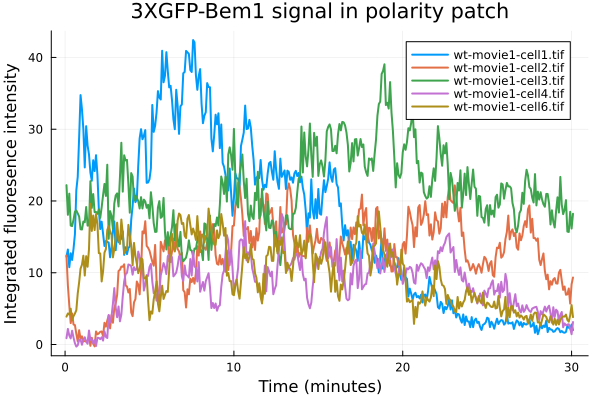

In [328]:
wt_files = readdir("../movies/2024_08_07-3XBG-pak1del/wt-1patch/")
plot(label="WT", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")
for f in wt_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/wt-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    plot!(t, mask_sum, linewidth=2, label=f, title="3XGFP-Bem1 signal in polarity patch")
end
plot!()

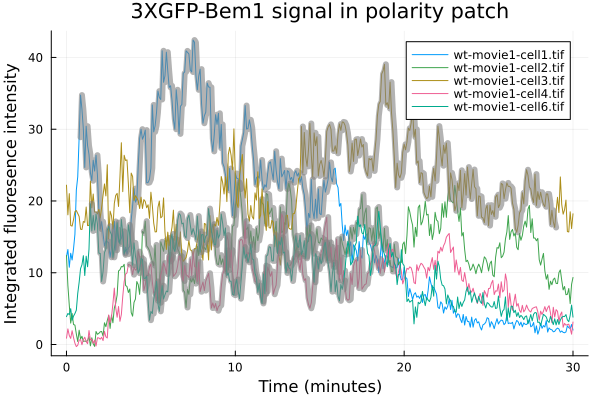

In [22]:
wt_files = readdir("../movies/2024_08_07-3XBG-pak1del/wt-1patch/")
plot(label="WT", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
for f in wt_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/wt-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    plot!(t, mask_sum, linewidth=1, label=f)
    thresh = 0.6
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    plot!(window_t, mask_sum[start:start+Integer(60/5*15)], linewidth=6, alpha=0.6, color="grey", label=false)
end
plot!()
#savefig("wt_signals.png")

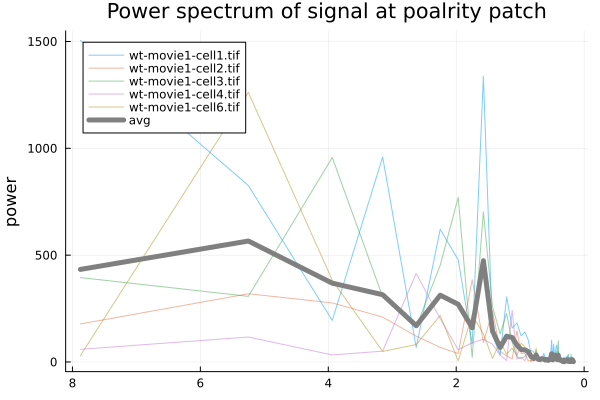

In [17]:
wt_files = readdir("../movies/2024_08_07-3XBG-pak1del/wt-1patch/")
plot(label="WT", ylabel="power", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
powers = zeros(95)
n=0
frequencies = 0
for f in wt_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/wt-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.6
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    crop_sum = mask_sum[start:start+Integer(60/5*15)]
    pdg = DSP.Periodograms.periodogram(crop_sum)
    plot!(1 ./ pdg.freq[3:end] .* (5/60), pdg.power[3:end], xflip = true, label=f, linewidth=1, title="Power spectrum of signal at poalrity patch", alpha=0.5)
    powers = powers .+ pdg.power
    frequencies = pdg.freq
    n+=1
end
plot!(1 ./ frequencies[3:end] .* (5/60), powers[3:end]/n, xflip = true, label="avg", linewidth=5, title="Power spectrum of signal at poalrity patch", color="grey")
#savefig("wt_periods.png")

In [58]:
del_files = readdir("../movies/2024_08_07-3XBG-pak1del/del-1patch/")
plot(label="del", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
for f in del_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/del-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    plot!(t, mask_sum, linewidth=1, label=f)
    thresh = 0.3
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    plot!(window_t, mask_sum[start:start+Integer(60/5*15)], linewidth=5, label=false, color="grey", alpha = 0.6)
end
plot!()
#savefig("del_signals.png")

"/home/dinosaur/Lab/Polarity/proj/PatchDynamics/notebooks/del_signals.png"

In [57]:
powers = zeros(95)
n=0
del_files = readdir("../movies/2024_08_07-3XBG-pak1del/del-1patch/")
plot(label="del", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
for f in del_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/del-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.3
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    crop_sum = mask_sum[start:start+Integer(60/5*15)]
    pdg = DSP.Periodograms.periodogram(crop_sum)
    plot!(1 ./ pdg.freq[3:end] .* (5/60), pdg.power[3:end], xflip = true, label=f, linewidth=1, title="Power spectrum of signal at poalrity patch", alpha=0.5)
    powers = powers .+ pdg.power
    n+=1 
end
plot!(1 ./ frequencies[3:end] .* (5/60), powers[3:end]/n, xflip = true, label="avg", linewidth=5, title="Power spectrum of signal at poalrity patch", color="grey")
#savefig("del_periods.png")

"/home/dinosaur/Lab/Polarity/proj/PatchDynamics/notebooks/del_periods.png"

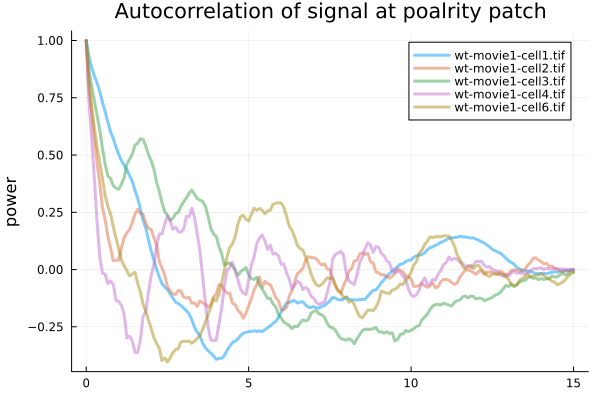

In [48]:
wt_files = readdir("../movies/2024_08_07-3XBG-pak1del/wt-1patch/")
plot(label="WT", ylabel="power", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
n=0
for f in wt_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/wt-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.6
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    crop_sum = mask_sum[start:start+Integer(60/5*15)]
    ac = autocor(crop_sum, range(0,length(crop_sum)-1))
    plot!(t, ac, label=f, linewidth=3, title="Autocorrelation of signal at poalrity patch", alpha=0.5)
    n+=1
end
plot!()
#savefig("wt_autocor.png")

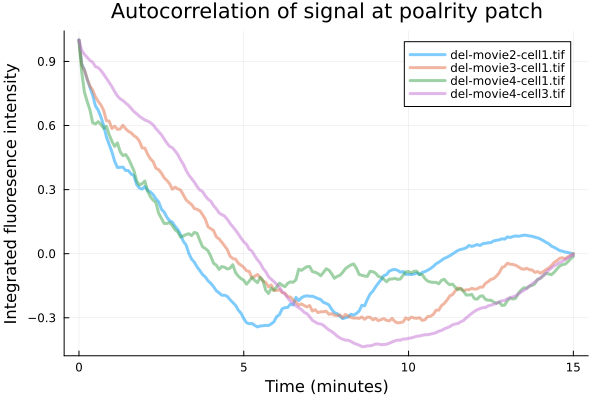

In [50]:
del_files = readdir("../movies/2024_08_07-3XBG-pak1del/del-1patch/")
plot(label="del", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
powers = zeros(95)
n=0
for f in del_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/del-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.3
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    crop_sum = mask_sum[start:start+Integer(60/5*15)]
    crop_sum = crop_sum .- mean(crop_sum)
    ac = autocor(crop_sum, range(0,length(crop_sum)-1))
    plot!(t, ac, label=f, linewidth=3, title="Autocorrelation of signal at poalrity patch", alpha=0.5)
    n+=1
end
plot!()
#savefig("del_autocor.png")

In [64]:
wt_files = readdir("../movies/2024_08_07-3XBG-pak1del/wt-1patch/")
plot(label="WT", ylabel="power", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
n=0
powers = zeros(95)
for f in wt_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/wt-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.6
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    crop_sum = mask_sum[start:start+Integer(60/5*15)]
    ac = autocor(crop_sum, range(0,length(crop_sum)-1))
    pdg = DSP.Periodograms.periodogram(ac)
    plot!(1 ./ pdg.freq[2:end] .* (5/60), pdg.power[2:end], xflip = true, label=f, linewidth=1, title="Power spectrum of signal at poalrity patch", alpha=0.5)
    powers = powers .+ pdg.power
    n+=1 
end
plot!(1 ./ frequencies[2:end] .* (5/60), powers[2:end]/n, xflip = true, label="avg", linewidth=5, title="Power spectrum of signal at poalrity patch", color="grey")
#savefig("wt_autocor_periods.png")

"/home/dinosaur/Lab/Polarity/proj/PatchDynamics/notebooks/wt_autocor_periods.png"

In [63]:
del_files = readdir("../movies/2024_08_07-3XBG-pak1del/del-1patch/")
plot(label="del", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
powers = zeros(95)
n=0
for f in del_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/del-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.3
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    crop_sum = mask_sum[start:start+Integer(60/5*15)]
    crop_sum = crop_sum .- mean(crop_sum)
    ac = autocor(crop_sum, range(0,length(crop_sum)-1))
    pdg = DSP.Periodograms.periodogram(ac)
    plot!(1 ./ pdg.freq[2:end] .* (5/60), pdg.power[2:end], xflip = true, label=f, linewidth=1, title="Power spectrum of signal at poalrity patch", alpha=0.5)
    powers = powers .+ pdg.power
    n+=1 
end
plot!(1 ./ frequencies[2:end] .* (5/60), powers[2:end]/n, xflip = true, label="avg", linewidth=5, title="Power spectrum of signal at poalrity patch", color="grey")
#savefig("del_autocor_periods.png")

"/home/dinosaur/Lab/Polarity/proj/PatchDynamics/notebooks/del_autocor_periods.png"

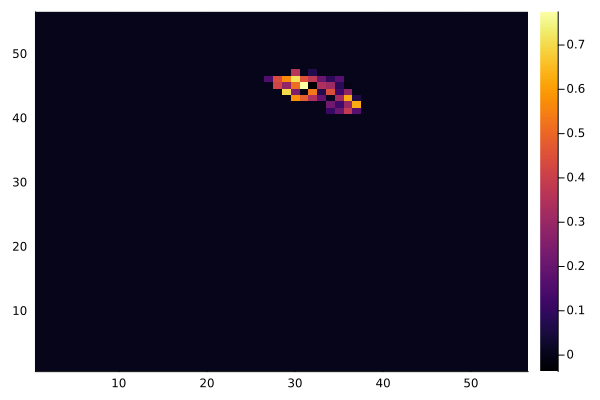

In [301]:
heatmap(mask[:,:,Integer(8*(60/5)),1])